In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import userinput

if userinput.Depth_drilling_possible:
    folder = "optimization_2_results_depth"
else:
    folder = "optimization_2_results"
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

In [2]:
all_dfs = pd.DataFrame(columns=['name', 'phi_standing', 'electricity_price', 'drilling_costs', 'Capex_TTES', 'objective_value', 'total_heat_supplied', 'costs_per_MWh'])


for f in csv_files:
    name = f
    f = pd.read_csv(os.path.join(folder, f))

    df_aux = pd.DataFrame({
        'name': [name],
        'phi_standing': [f['phi_standing'].iloc[0]],
        'electricity_price': [f['electricity_price'].iloc[0]],
        'drilling_costs': [f['drilling_costs'].iloc[0]],
        'Capex_TTES': [f['Capex_TTES'].iloc[0]],
        'objective_value': [f['objective_value'].iloc[0]],
        'total_heat_supplied': [f['total_heat_supplied'].iloc[0]],
        'costs_per_MWh_produced': [f['costs_per_MWh_produced'].iloc[0]],
        'costs_per_MWh_demand': [f['costs_per_MWh_demand'].iloc[0]],
        'sum_ATES_charge': [f['ATES_charge'].sum()],
        'sum_ATES_discharge': [f['ATES_discharge'].sum()],
        'ATES_capacity': [f['ATES_capacity'].iloc[0]]
    })
    all_dfs = pd.concat([all_dfs, df_aux], ignore_index=True)

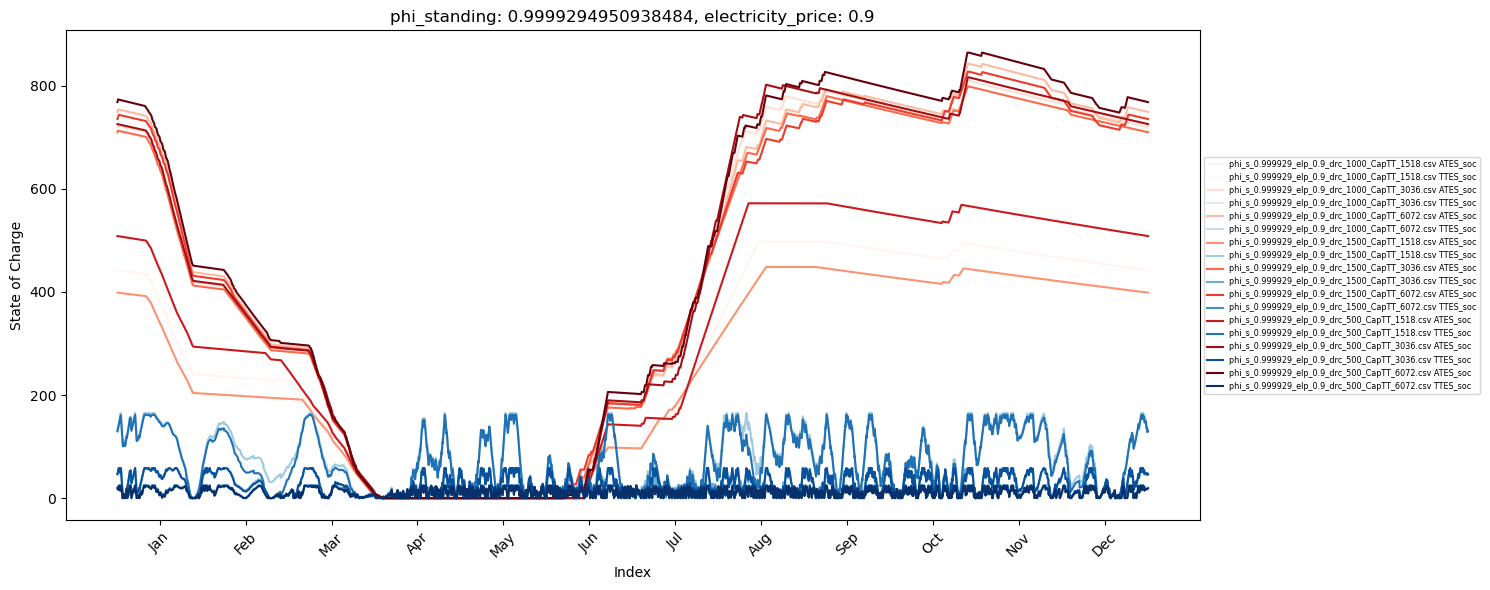

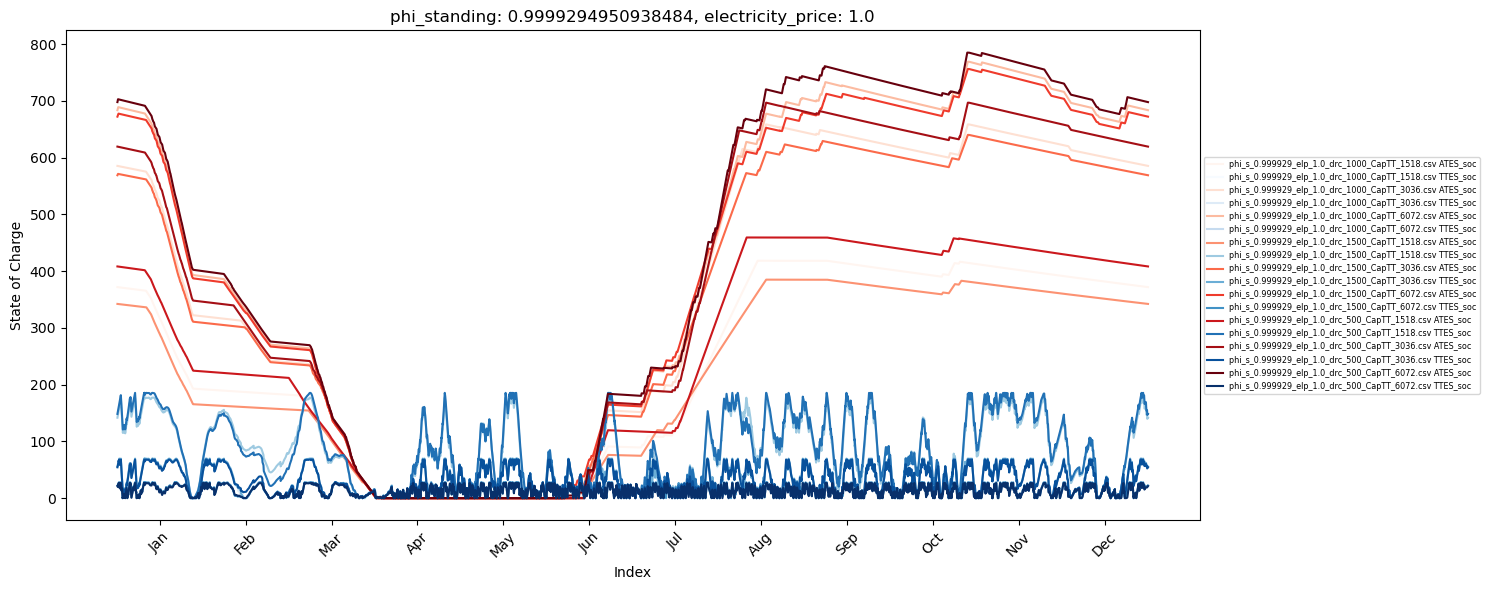

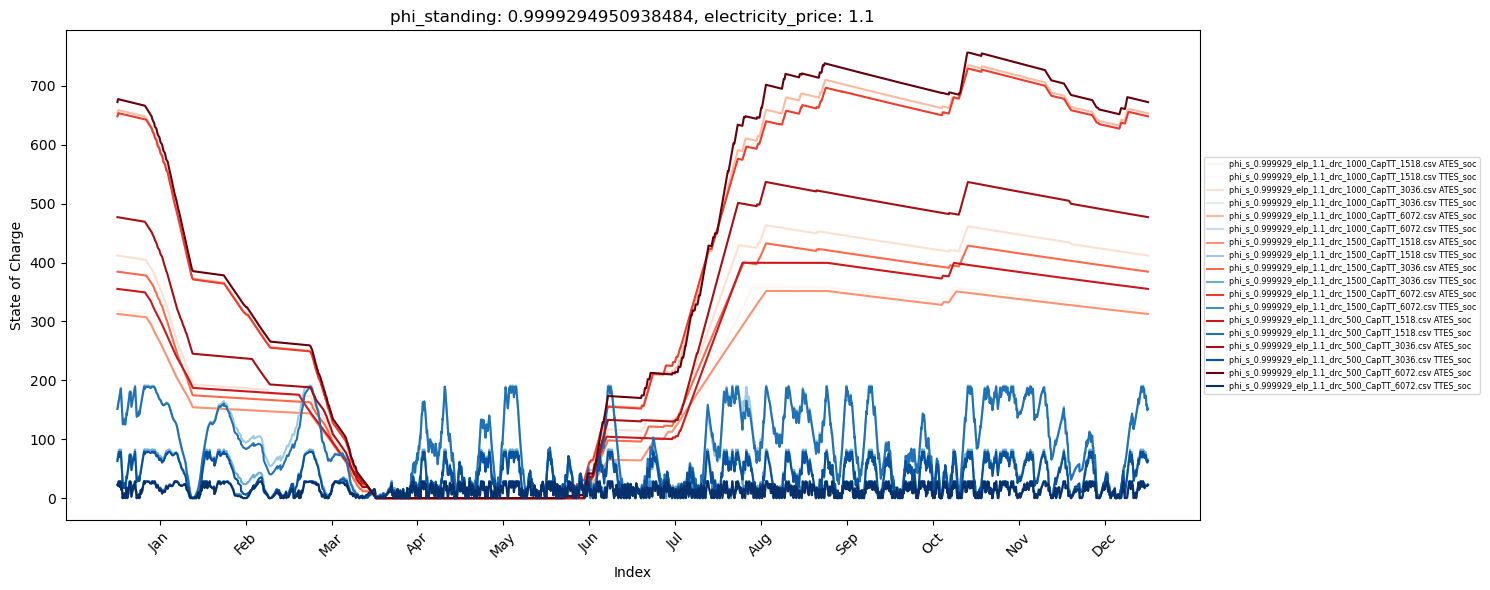

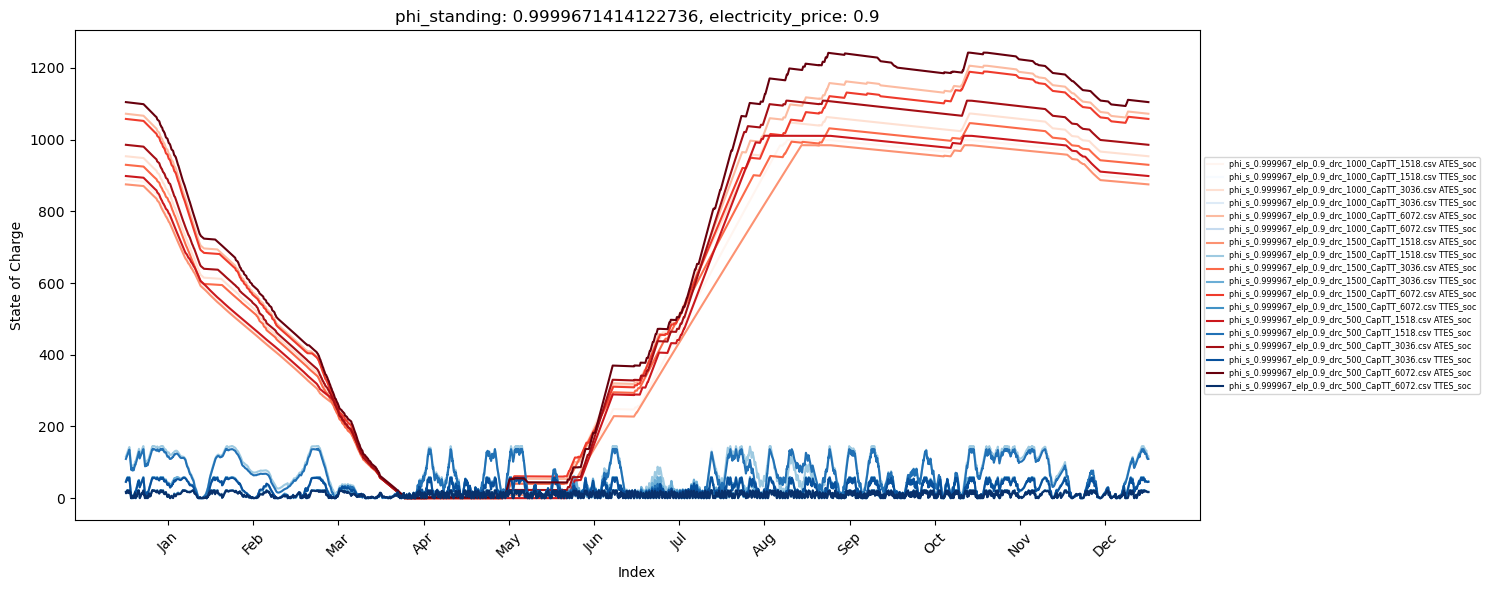

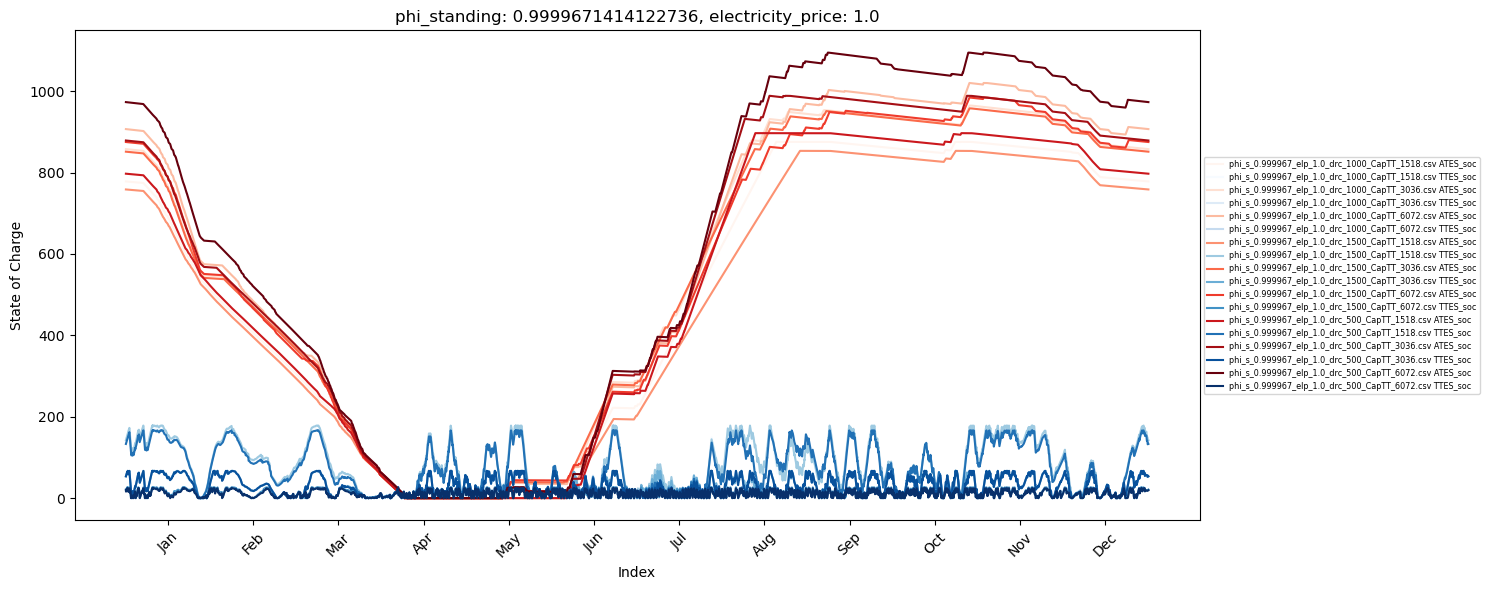

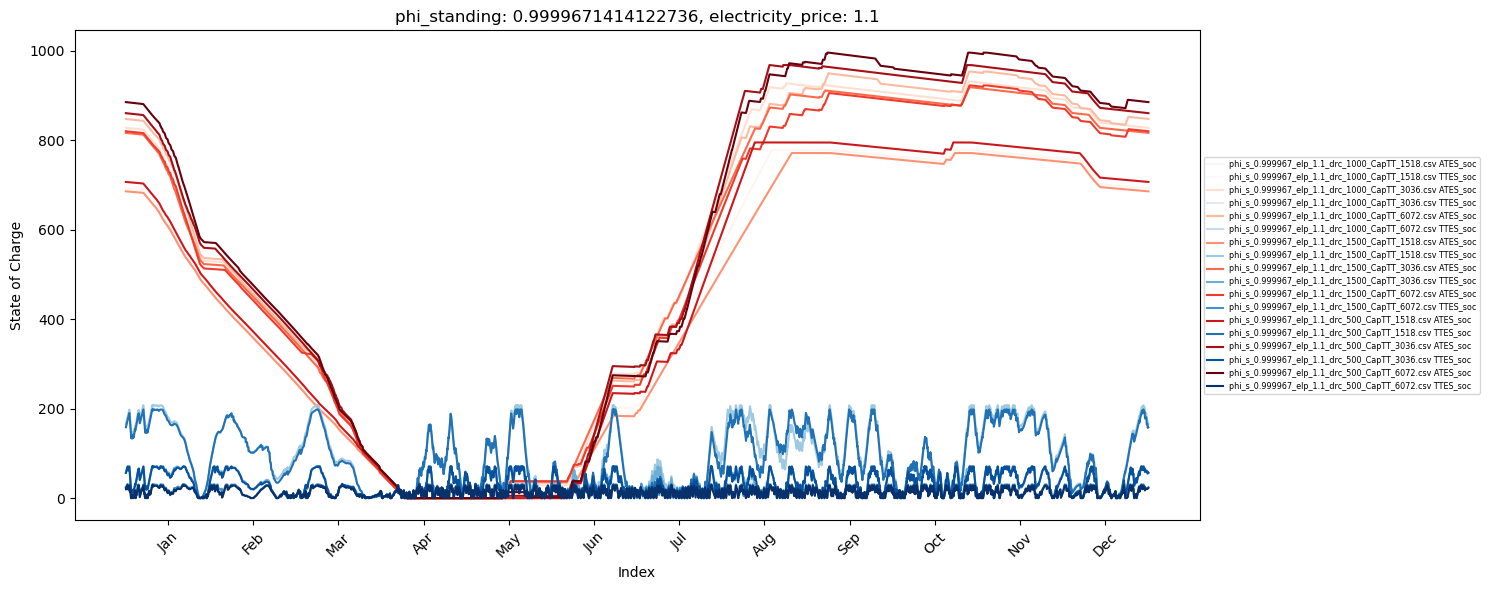

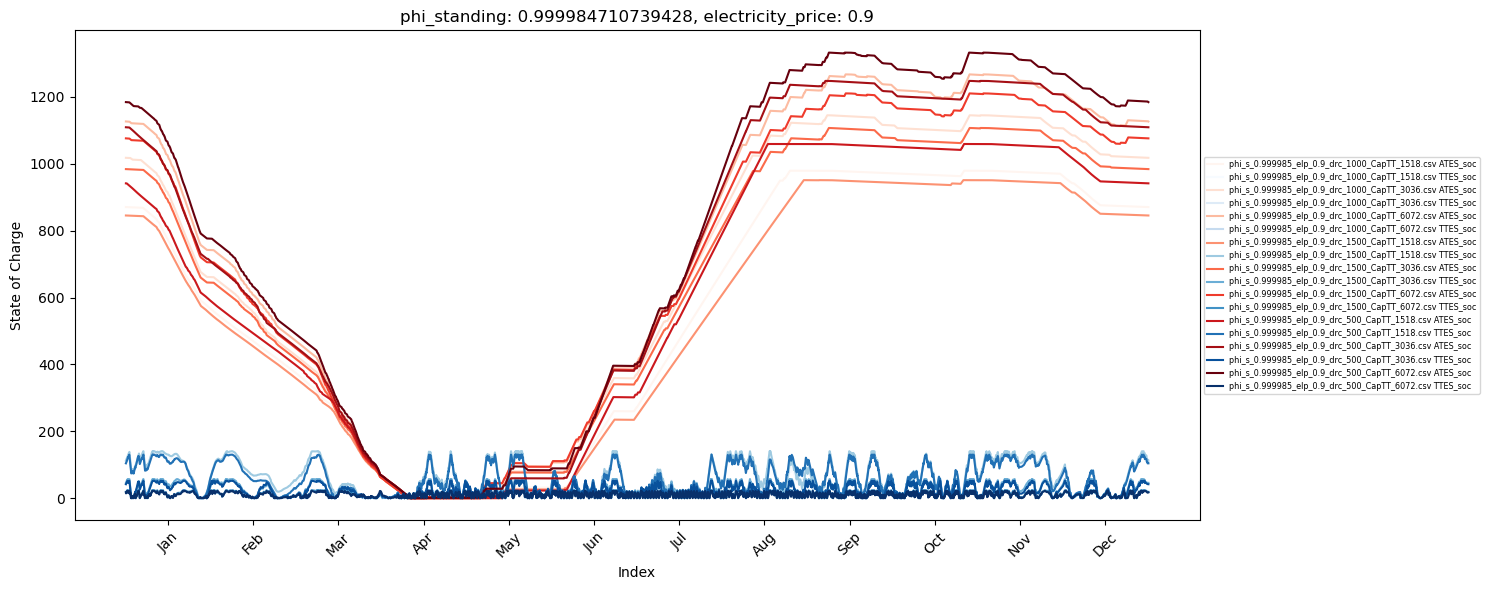

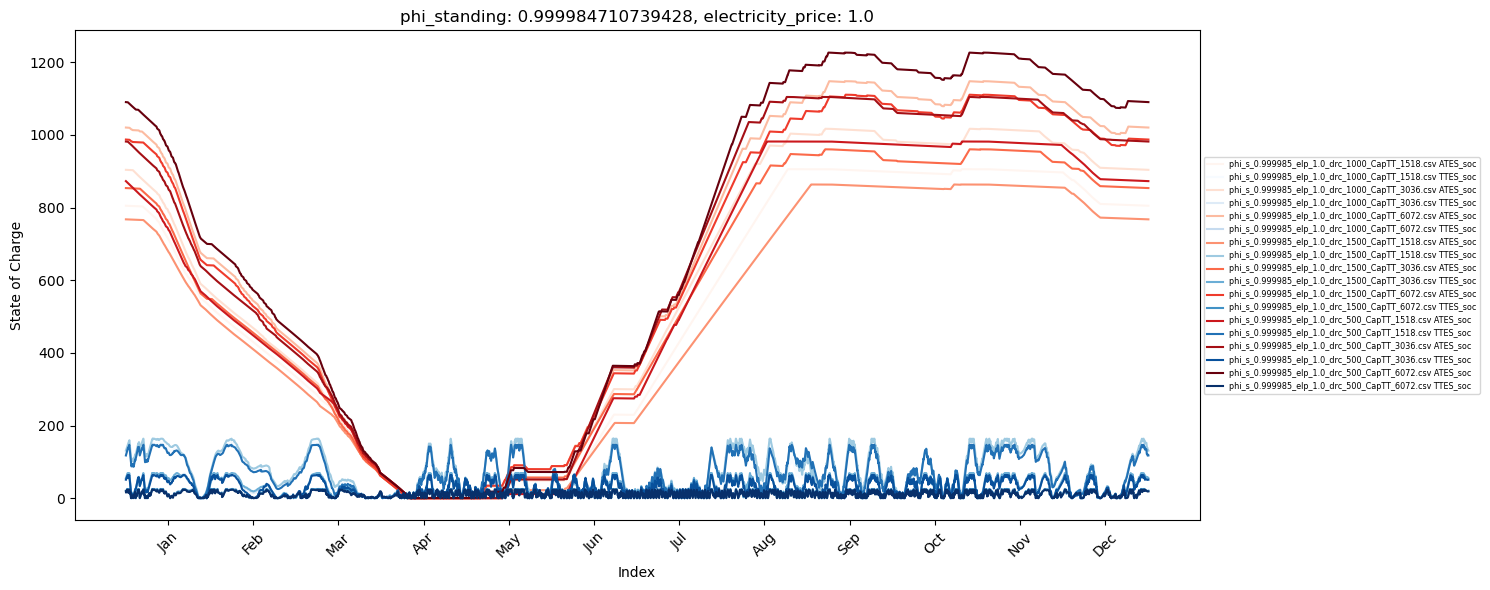

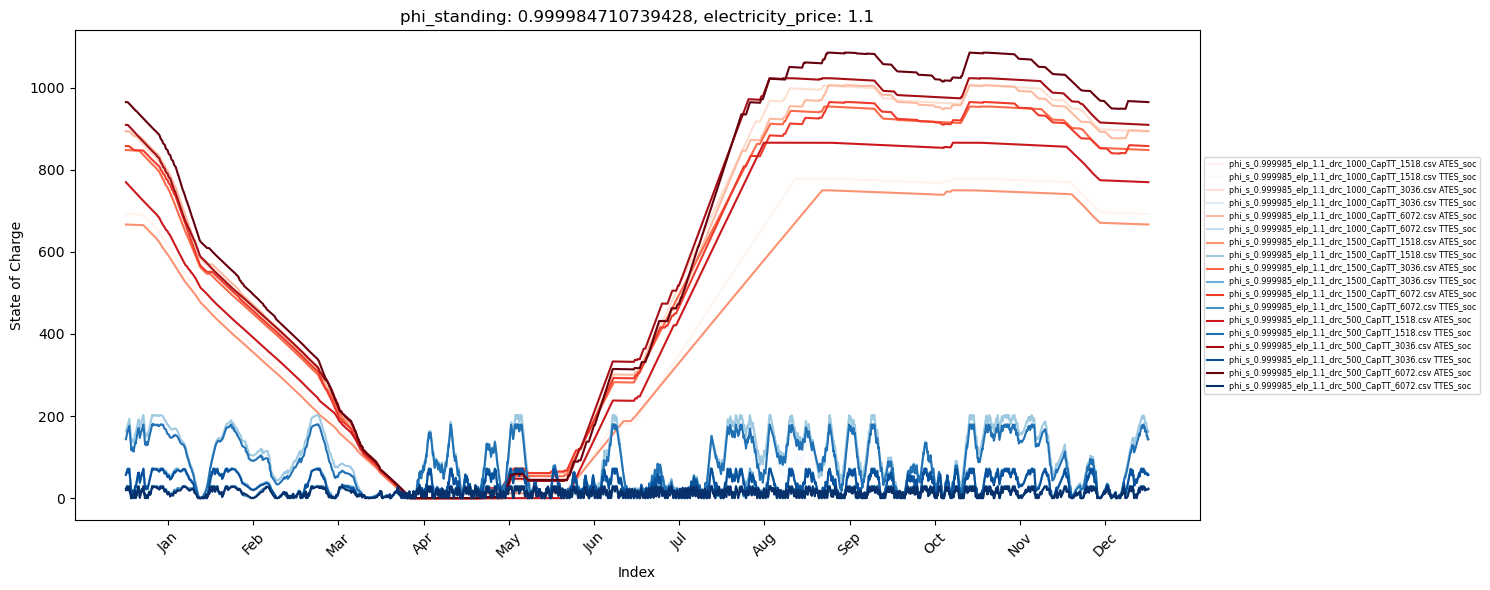

In [3]:
grouped = all_dfs.groupby(['phi_standing', 'electricity_price'])
for idx, ((phi, price), group) in enumerate(grouped):
    num_group_files = len(all_dfs[(all_dfs['phi_standing'] == phi) & (all_dfs['electricity_price'] == price)])

    red_cmap = matplotlib.colormaps['Reds'].resampled(num_group_files)
    blue_cmap = matplotlib.colormaps['Blues'].resampled(num_group_files)

    plt.figure(figsize=(15, 6))
    handles = []
    labels = []
    color_idx = 0
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        h1, = plt.plot(df['ATES_soc'], color=red_cmap(color_idx), label=f'{fname} ATES_soc')
        h2, = plt.plot(df['TTES_soc'], color=blue_cmap(color_idx), label=f'{fname} TTES_soc')
        handles.extend([h1, h2])
        labels.extend([f'{fname} ATES_soc', f'{fname} TTES_soc'])
        color_idx += 1
    plt.title(f'phi_standing: {phi}, electricity_price: {price}')
    plt.xlabel('Index')
    plt.ylabel('State of Charge')
    tick_locs = range(15*24, len(df['datetime']), 8760 // 12)
    tick_labels = pd.to_datetime(df['datetime']).dt.strftime('%b')[list(tick_locs)]
    plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)
    #plt.ylim(0, 7500)
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.tight_layout()
    plt.show()

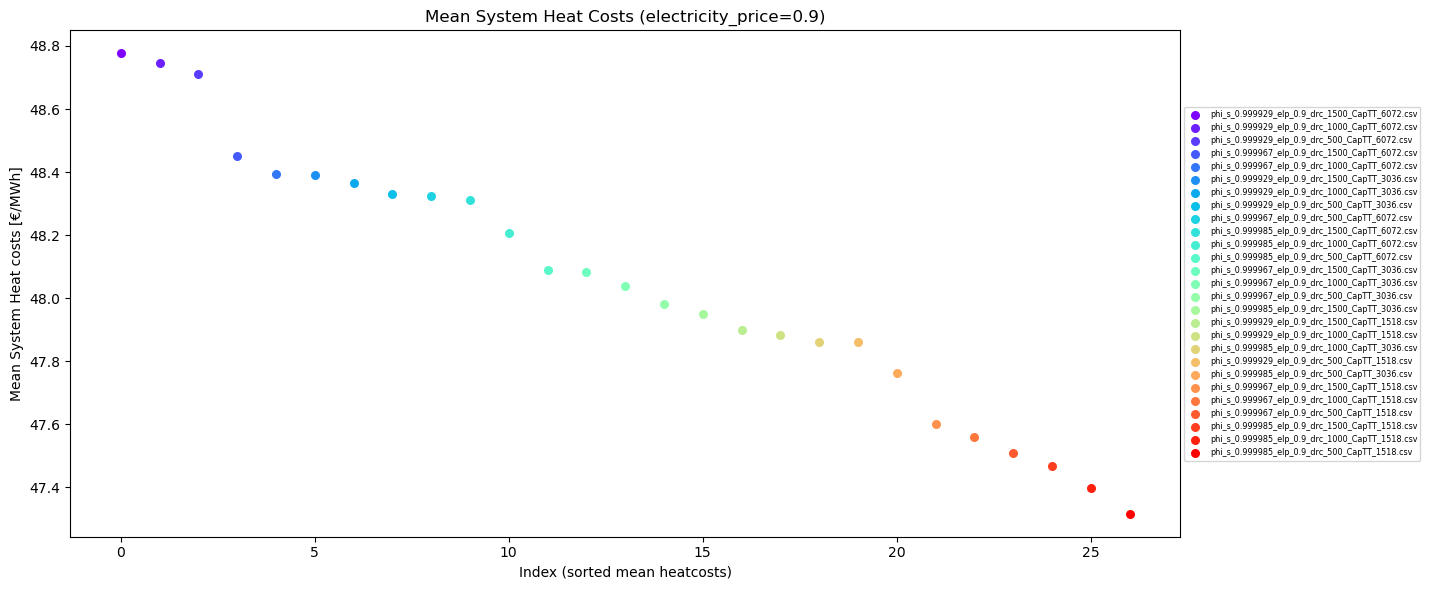

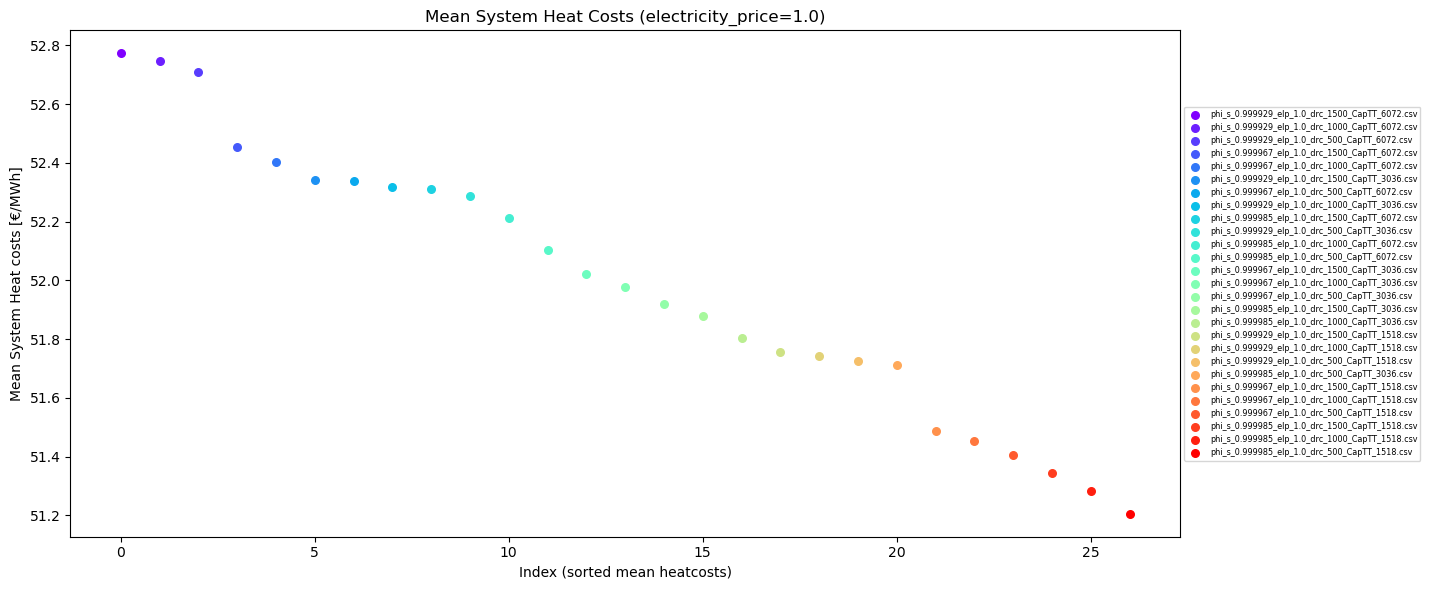

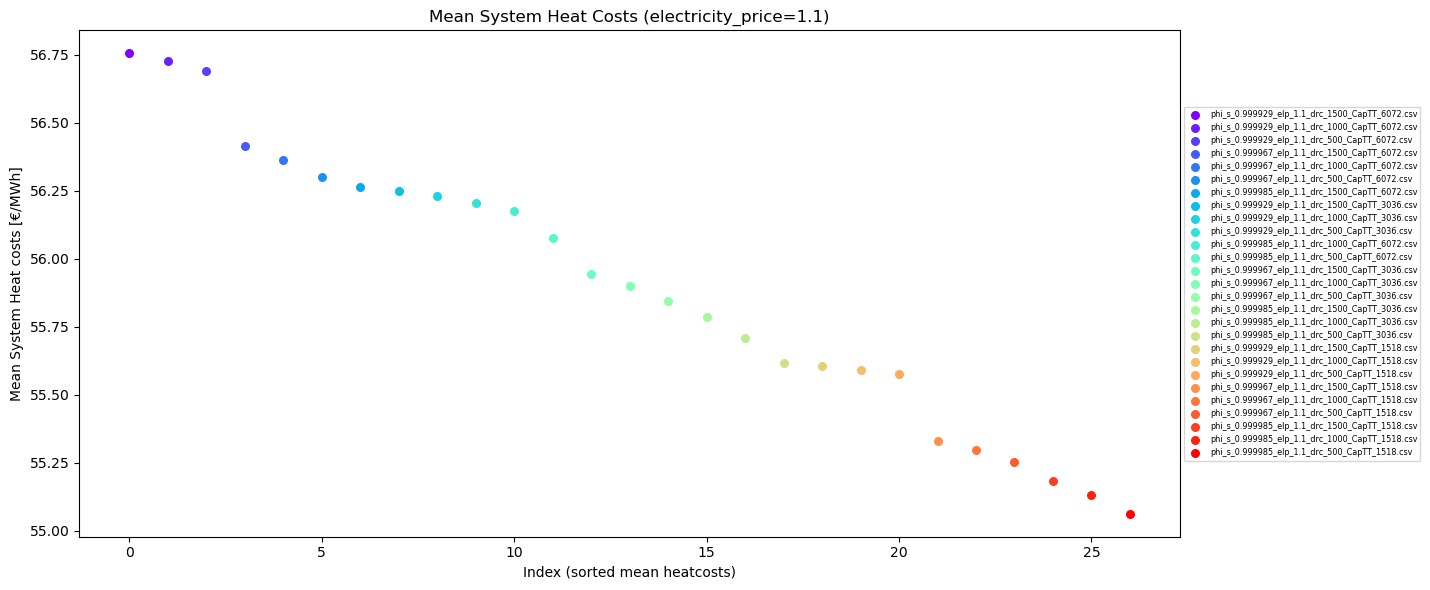

In [4]:
grouped_by_price = all_dfs.groupby('electricity_price')

for price, group in grouped_by_price:
    heatcost_means = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

    all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=group['name'])
    sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
    num_points = len(sorted_means)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (name, mean_val) in enumerate(sorted_means.items()):
        plt.scatter(i, mean_val, color=colors[i], s=30, label=name)
    plt.xlabel('Index (sorted mean heatcosts)')
    plt.ylabel('Mean System Heat costs [€/MWh]')
    plt.title(f'Mean System Heat Costs (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

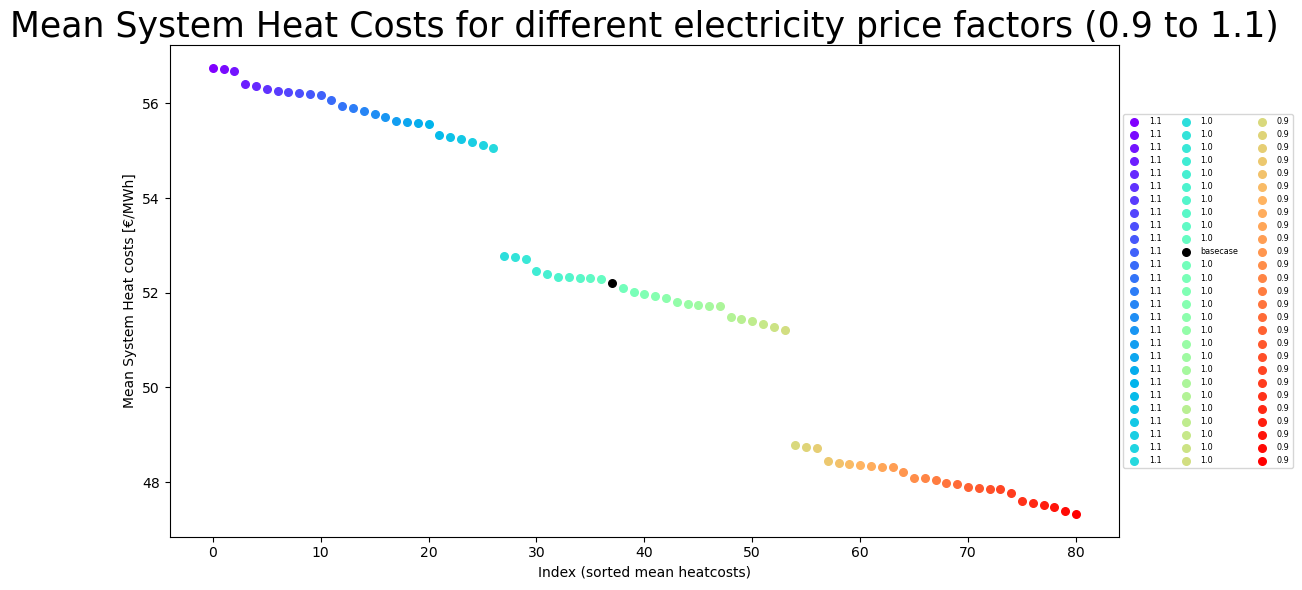

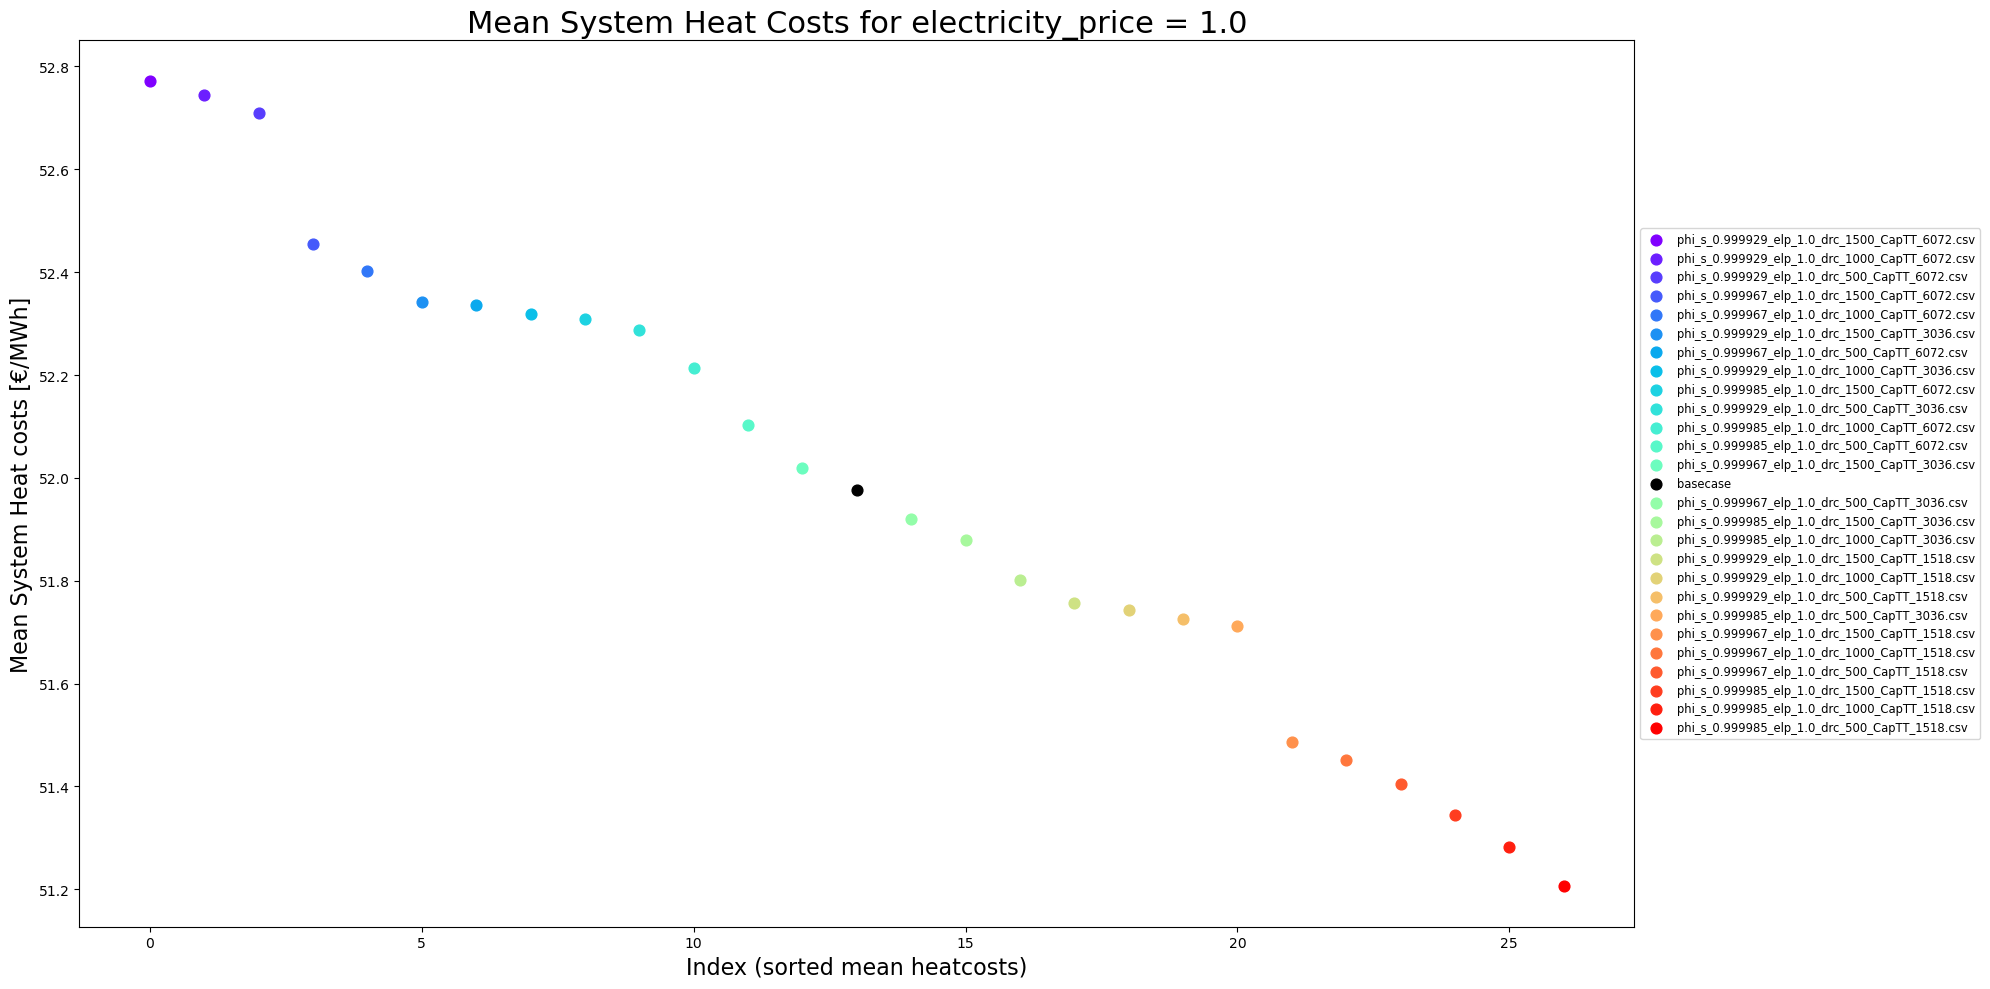

In [13]:
grouped_by_price = all_dfs.groupby('electricity_price')

# Prepare sorted_means and colors for the first plot
heatcost_means = []
for fname in all_dfs['name']:
    df_path = os.path.join(folder, fname)
    df = pd.read_csv(df_path)
    heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=all_dfs['name'])
sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
num_points = len(sorted_means)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]

plt.figure(figsize=(12, 6))
highlight_name = 'phi_s_0.999967_elp_1.0_drc_1000_CapTT_3036.csv'
highlight_idx = None

for i, (name, mean_val) in enumerate(sorted_means.items()):
    price_entry = all_dfs.loc[all_dfs['name'] == name, 'electricity_price'].values[0]
    if all_dfs['name'].iloc[i] == highlight_name:
        plt.scatter(i, mean_val, color='black', s=30, label=f'basecase', zorder=10)
        highlight_idx = i
    else:
        plt.scatter(i, mean_val, color=colors[i], s=30, label=str(price_entry))

if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=3)
plt.ylabel('Mean System Heat costs [€/MWh]')
plt.xlabel('Index (sorted mean heatcosts)')
plt.title(f'Mean System Heat Costs for different electricity price factors (0.9 to 1.1)', fontsize=25)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=3)
plt.show()



# Filter for electricity_price == 1.0
all_dfs_electr1 = all_dfs[all_dfs['electricity_price'] == 1.0]

heatcost_means = []
for fname in all_dfs_electr1['name']:
    df_path = os.path.join(folder, fname)
    df = pd.read_csv(df_path)
    heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=all_dfs_electr1['name'])
sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
num_points = len(sorted_means)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]

plt.figure(figsize=(20, 10))
highlight_name = 'phi_s_0.999967_elp_1.0_drc_1000_CapTT_3036.csv'
highlight_idx = None

for i, (name, mean_val) in enumerate(sorted_means.items()):
    if name == highlight_name:
        plt.scatter(i, mean_val, color='black', s=60, label='basecase', zorder=10)
        highlight_idx = i
    else:
        plt.scatter(i, mean_val, color=colors[i], s=60, label=name)

if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.ylabel('Mean System Heat costs [€/MWh]', fontsize=16)
plt.xlabel('Index (sorted mean heatcosts)', fontsize=16)
plt.title('Mean System Heat Costs for electricity_price = 1.0', fontsize=22)
plt.tight_layout()
plt.show()


In [6]:
all_dfs.iloc[0]


name                      phi_s_0.999929_elp_0.9_drc_1000_CapTT_1518.csv
phi_standing                                                    0.999929
electricity_price                                                    0.9
drilling_costs                                                      1000
Capex_TTES                                                          1518
objective_value                                           1138289.974527
total_heat_supplied                                         24234.585949
costs_per_MWh                                                        NaN
costs_per_MWh_produced                                         46.969648
costs_per_MWh_demand                                           47.882308
sum_ATES_charge                                               733.666468
sum_ATES_discharge                                             318.90874
ATES_capacity                                                 552.870849
Name: 0, dtype: object

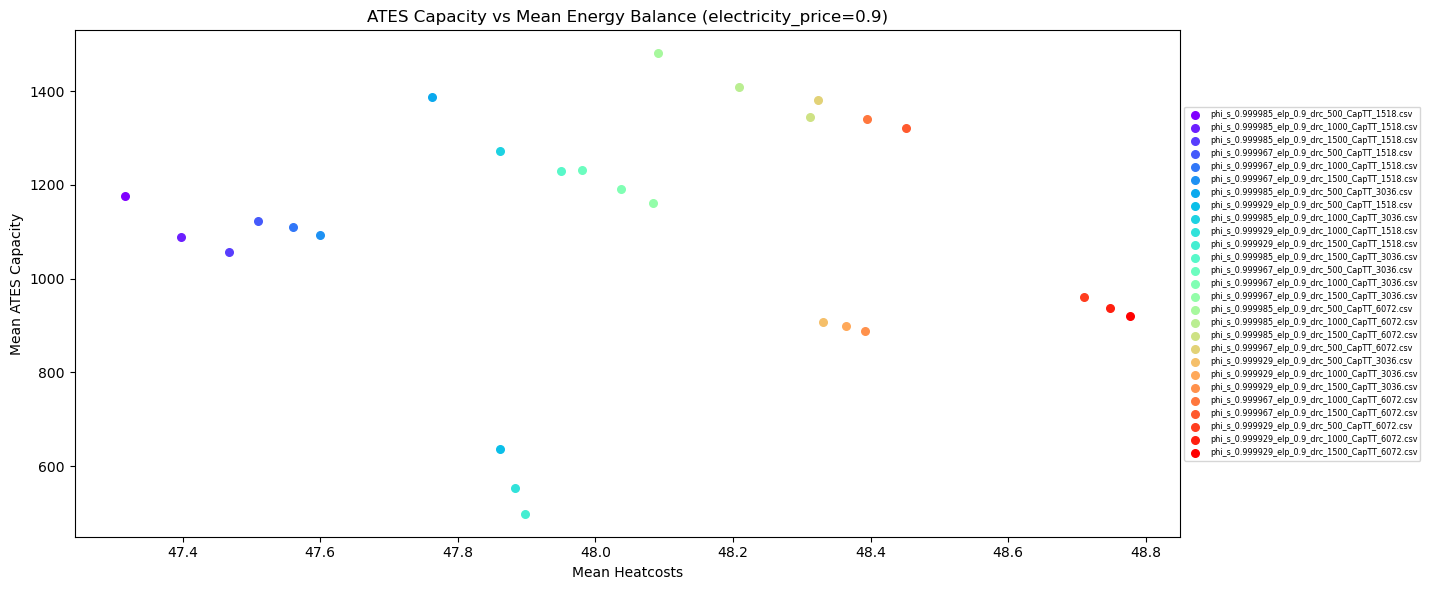

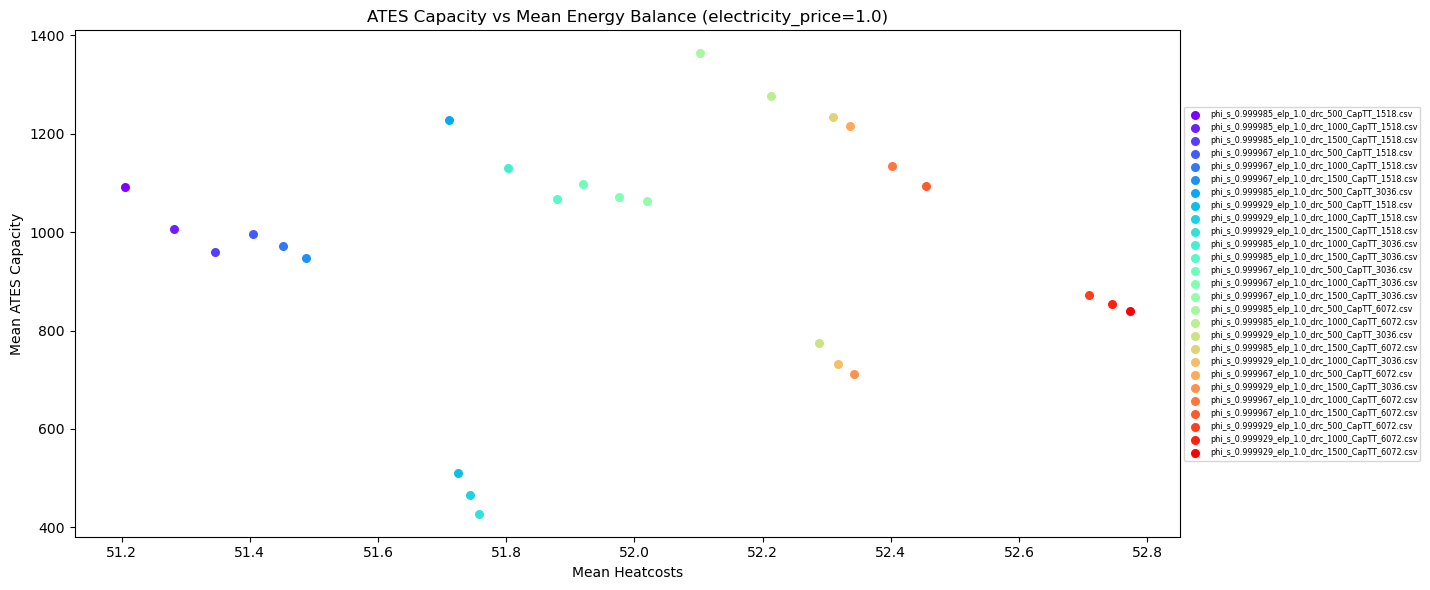

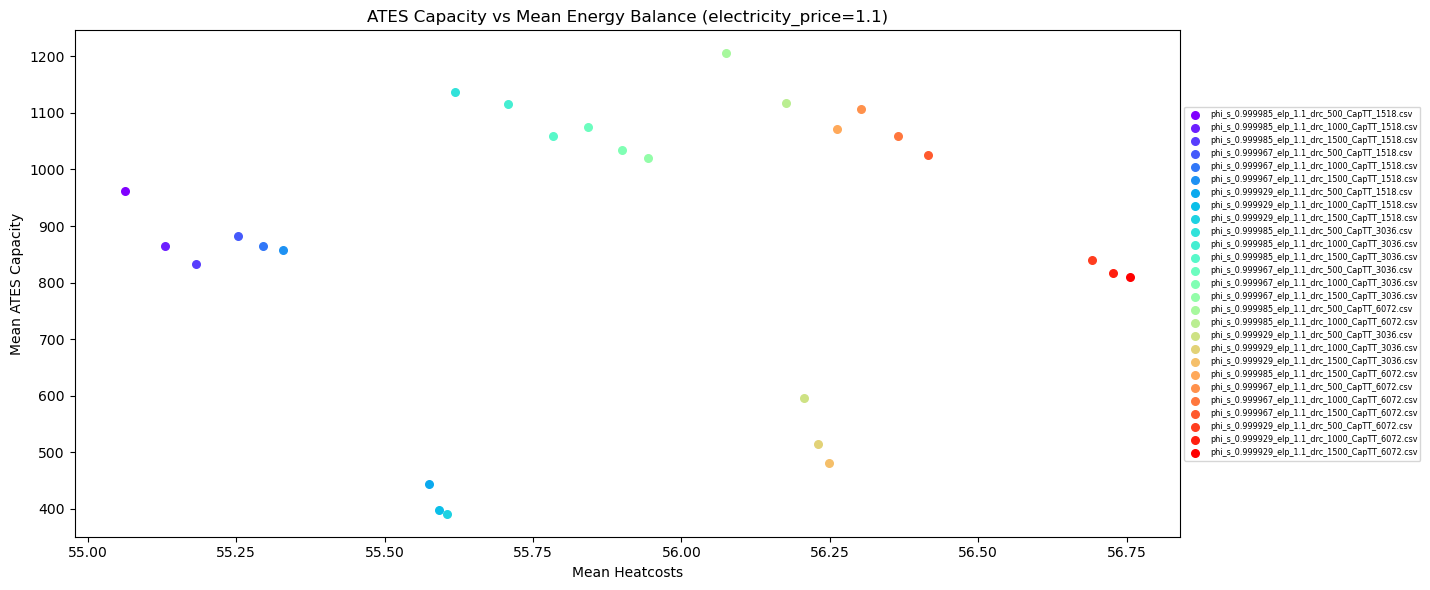

In [14]:
grouped_by_price = all_dfs.groupby('electricity_price')

for price, group in grouped_by_price:
    heatcost_means = []
    ates_capacity = []
    names = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])
        ates_capacity.append(df['ATES_capacity'].mean())
        names.append(fname)

    # Sort by mean_energy_balance
    sorted_data = sorted(zip(heatcost_means, ates_capacity, names), key=lambda x: x[0])
    sorted_mean_heatcosts, sorted_ates_capacity, sorted_names = zip(*sorted_data)

    num_points = len(sorted_mean_heatcosts)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (x, y, name) in enumerate(zip(sorted_mean_heatcosts, sorted_ates_capacity, sorted_names)):
        plt.scatter(x, y, color=colors[i], s=30, label=name)
    plt.xlabel('Mean Heatcosts')
    plt.ylabel('Mean ATES Capacity')
    plt.title(f'ATES Capacity vs Mean Energy Balance (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

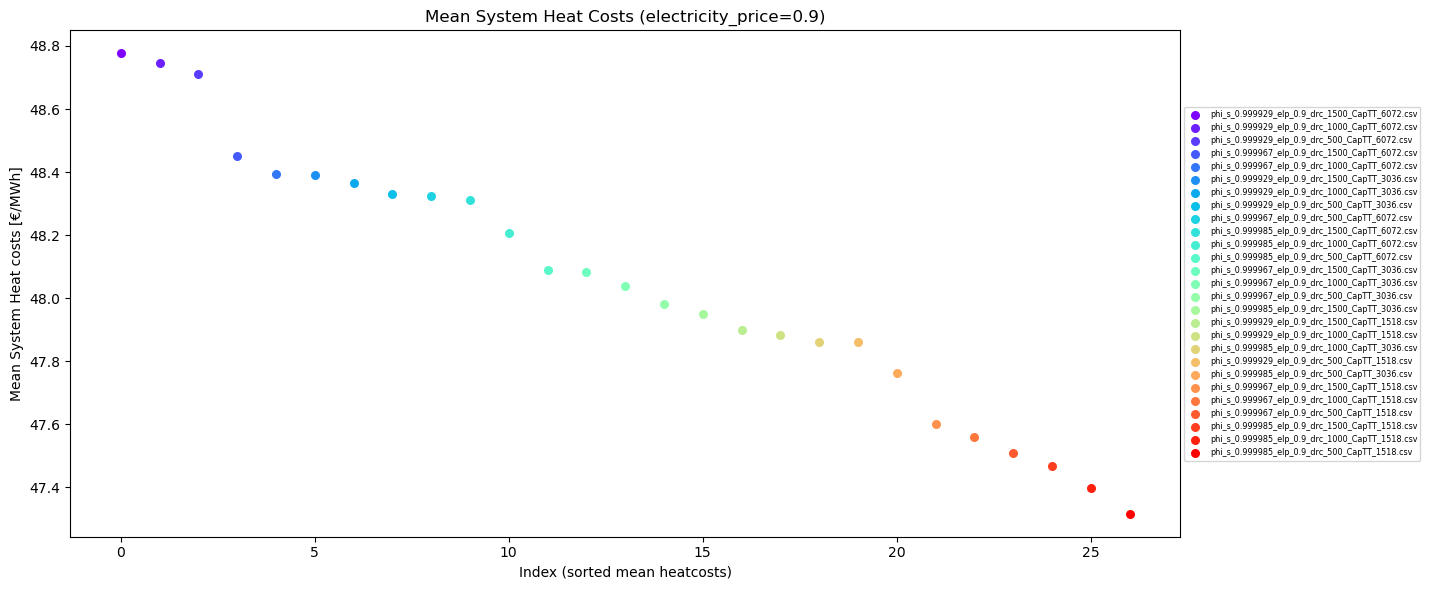

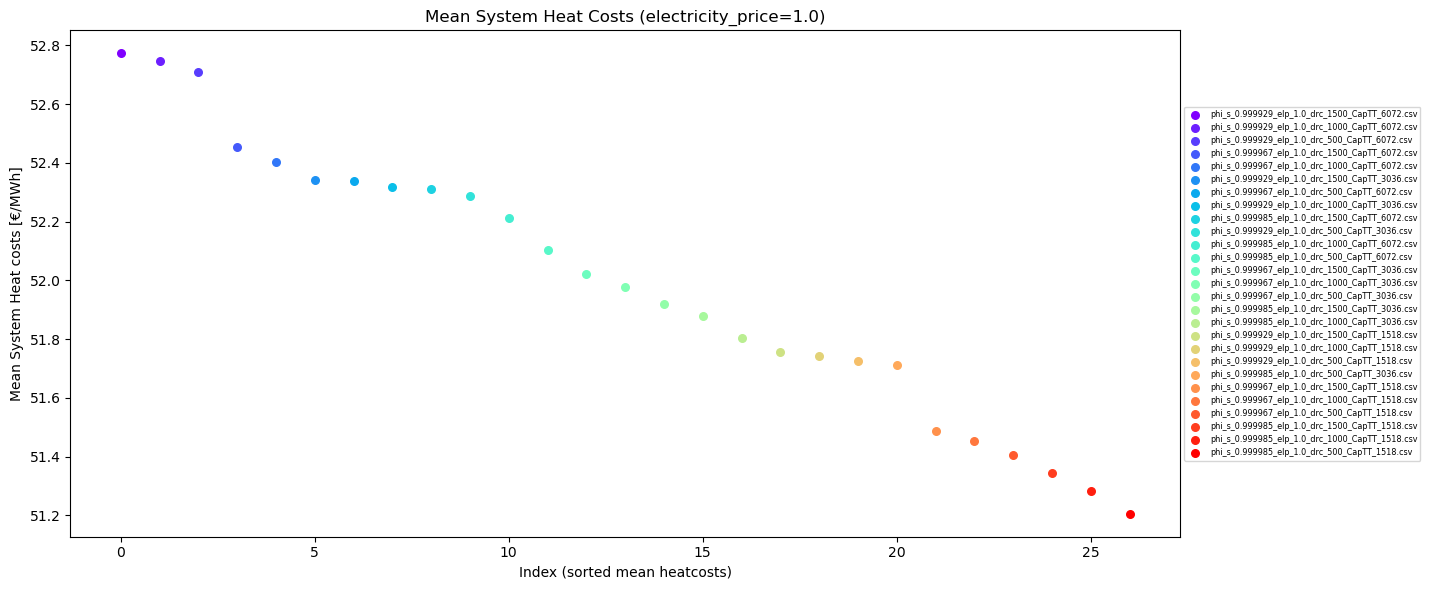

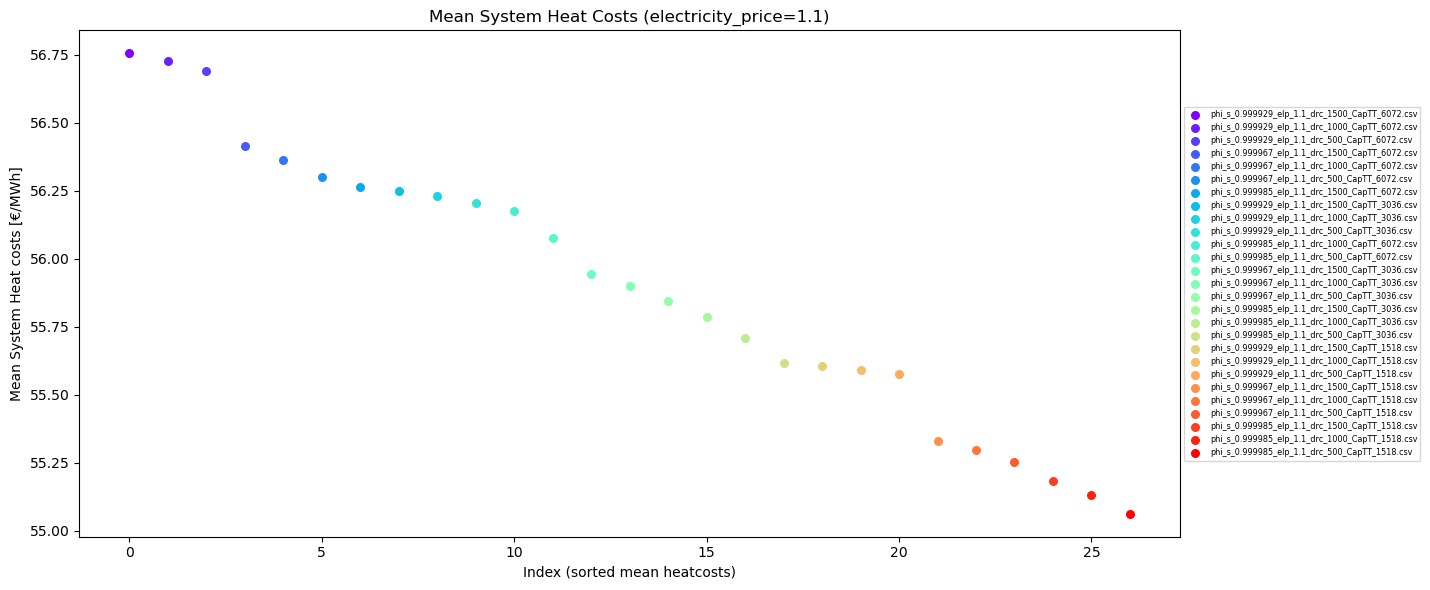

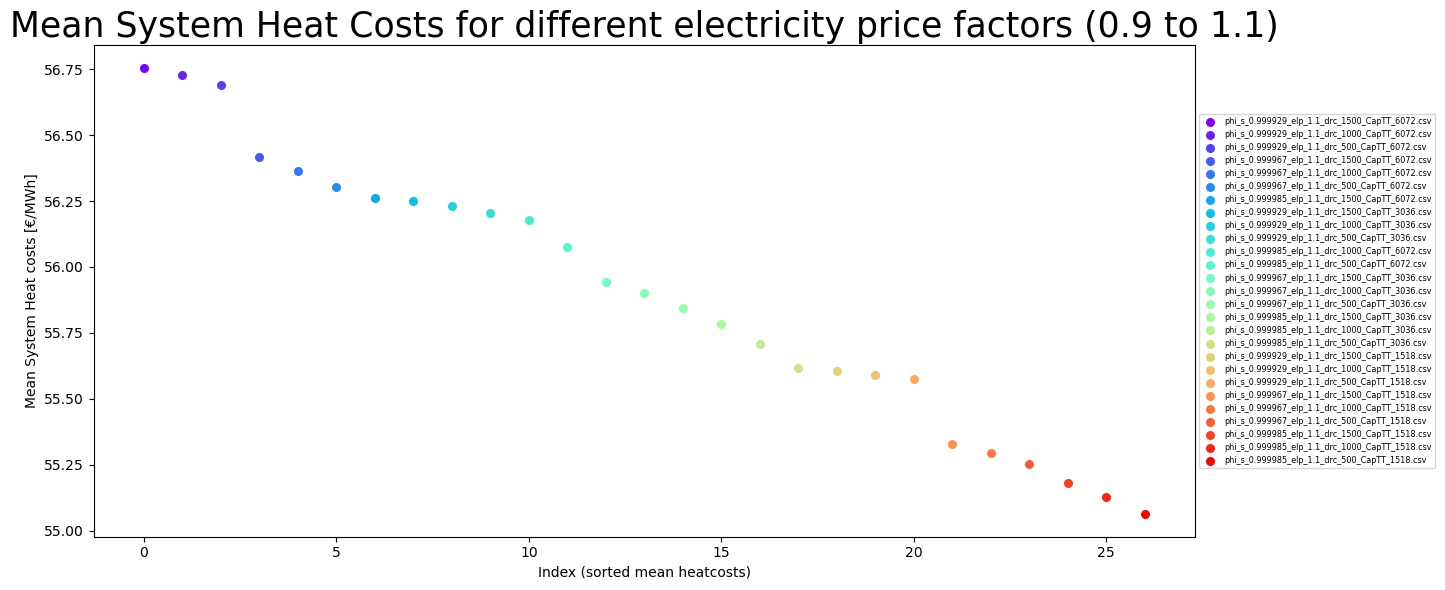

In [17]:
grouped_by_price = all_dfs.groupby('electricity_price')

for price, group in grouped_by_price:
    heatcost_means = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

    all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=group['name'])
    sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
    num_points = len(sorted_means)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (name, mean_val) in enumerate(sorted_means.items()):
        plt.scatter(i, mean_val, color=colors[i], s=30, label=name)
    plt.xlabel('Index (sorted mean heatcosts)')
    plt.ylabel('Mean System Heat costs [€/MWh]')
    plt.title(f'Mean System Heat Costs (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

plt.figure(figsize=(12, 6))
highlight_name = 'phi_s_0.999967_elp_1.0_drc_1000_CapTT_3036.csv'
highlight_idx = None

sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
num_points = len(sorted_means)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]


for i, (name, mean_val) in enumerate(sorted_means.items()):
    if all_dfs['name'].iloc[i] == highlight_name:
        plt.scatter(i, mean_val, color='black', s=30, label=f'basecase', zorder=10)
        highlight_idx = i
    else:
        plt.scatter(i, mean_val, color=colors[i], s=30, label=name)

if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=3)
plt.ylabel('Mean System Heat costs [€/MWh]')
plt.xlabel('Index (sorted mean heatcosts)')
plt.title(f'Mean System Heat Costs for different electricity price factors (0.9 to 1.1)', fontsize=25)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=1)
plt.show()


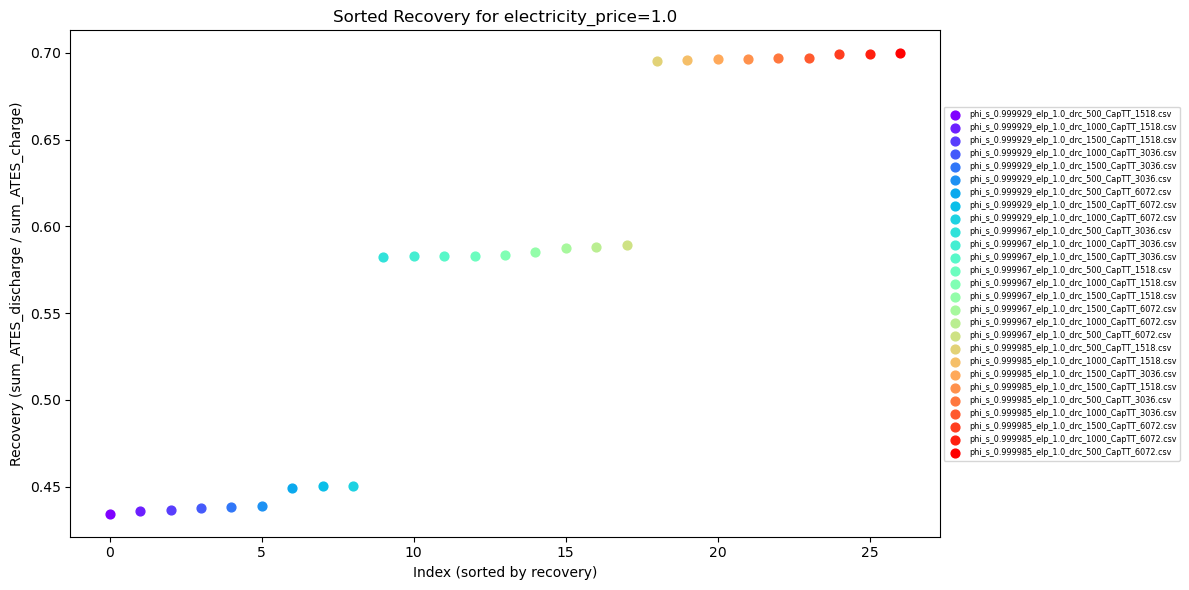

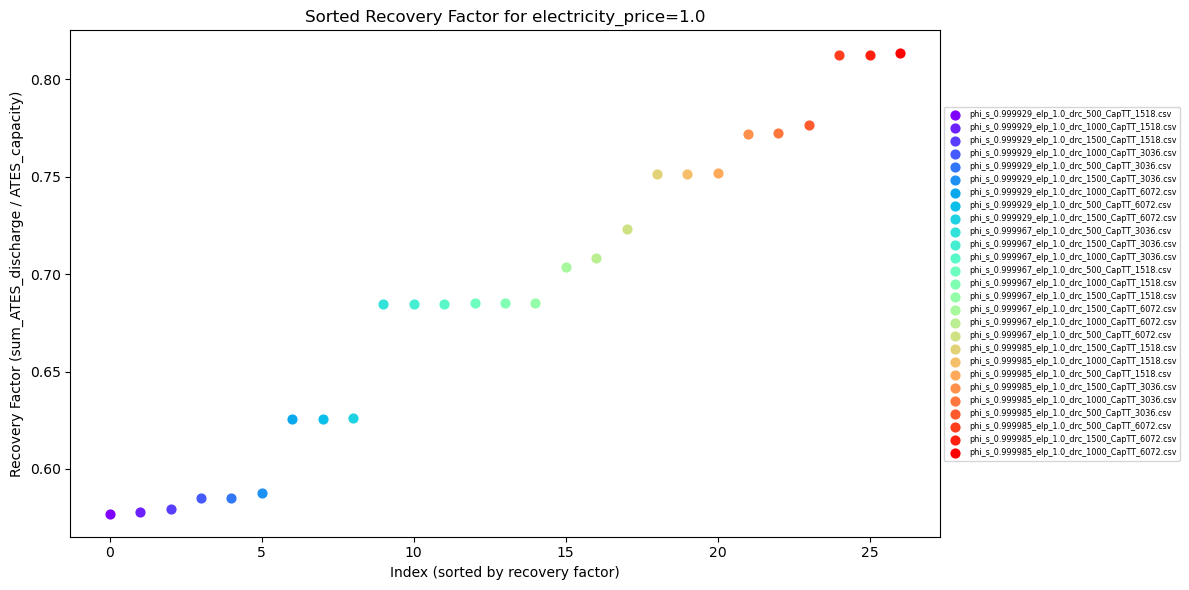

In [16]:
# Filter and assign both columns in a single step for efficiency
all_dfs_electr1 = all_dfs[all_dfs['electricity_price'] == 1.0].copy()
all_dfs_electr1['recovery'] = all_dfs_electr1['sum_ATES_discharge'] / all_dfs_electr1['sum_ATES_charge']
all_dfs_electr1['recov_fac'] = all_dfs_electr1['sum_ATES_discharge'] / all_dfs_electr1['ATES_capacity']

num_points = len(all_dfs_electr1)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]


# Sorted recovery plot
plt.figure(figsize=(12, 6))
sorted_recovery = all_dfs_electr1.sort_values('recovery')
for i, (idx, row) in enumerate(sorted_recovery.iterrows()):
    plt.scatter(i, row['recovery'], color=colors[i], s=40, label=row['name'])
plt.xlabel('Index (sorted by recovery)')
plt.ylabel('Recovery (sum_ATES_discharge / sum_ATES_charge)')
plt.title('Sorted Recovery for electricity_price=1.0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
plt.tight_layout()
plt.show()

# Sorted recovery factor plot
plt.figure(figsize=(12, 6))
sorted_recov_fac = all_dfs_electr1.sort_values('recov_fac')
for i, (idx, row) in enumerate(sorted_recov_fac.iterrows()):
    plt.scatter(i, row['recov_fac'], color=colors[i], s=40, label=row['name'])
plt.xlabel('Index (sorted by recovery factor)')
plt.ylabel('Recovery Factor (sum_ATES_discharge / ATES_capacity)')
plt.title('Sorted Recovery Factor for electricity_price=1.0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
plt.tight_layout()
plt.show()